In [1]:
import lettuce as lt

In [2]:
class ShanChenCollision(lt.BGKCollision):
    def __init__(self, lattice, tau, G):
        super().__init__(lattice, tau)
        self.force = lt.Guo(lattice, tau, 0.0)
        self.G = G
    
    def __call__(self, f):
        rho = self.lattice.rho(f)
        drho = lt.torch_gradient(rho[0])
        self.force.acceleration = self.compute_force(rho, drho, self.G)
        u_eq = 0 if self.force is None else self.force.u_eq(f)
        u = self.lattice.u(f) + u_eq
        feq = self.lattice.equilibrium(rho, u)
        Si = 0 if self.force is None else self.force.source_term(u)
        return f - 1.0 / self.tau * (f - feq) + Si
    
    rho0 = 1.0
    
    def _psi(self, rho):
        return 1. - torch.exp(-rho/self.rho0)
    
    def _dpsi(self, rho):
        return torch.exp(-rho/self.rho0)
    
    def compute_force(self, rho, drho, G):
        return - G * self._psi(rho) * self._dpsi(rho) * drho

In [3]:
lattice = lt.Lattice(lt.D2Q9, "cuda:0")
collision = ShanChenCollision(lattice, 1.0, G=2.0)
streaming = lt.StandardStreaming(lattice)

In [4]:
import torch
device = torch.device("cuda:0")
f = lattice.equilibrium(
    rho=1.0*torch.ones(1, 100, 100, device=device) + 0.011*torch.randn(1, 100, 100, device=device),
    u=torch.zeros(2, 100, 100, device=device)
)
    

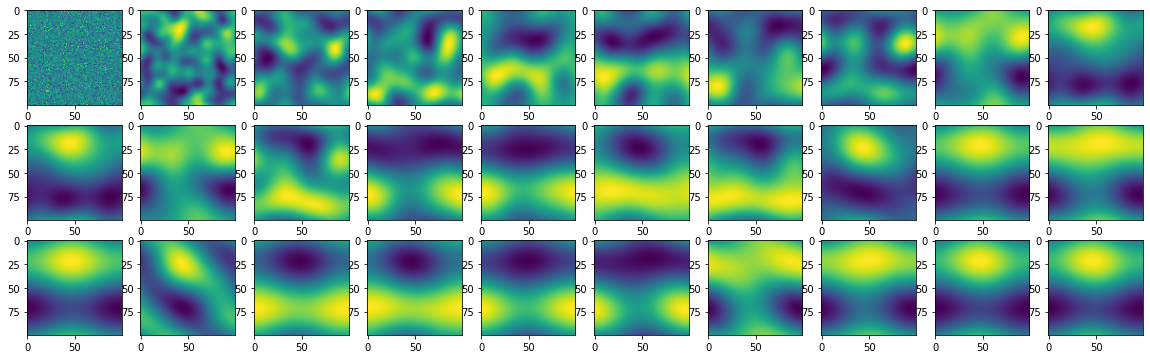

In [5]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
axes = axes.flatten()
for ax, _ in zip(axes, range(30)):
    ax.imshow(lattice.rho(f)[0].detach().cpu().numpy())
    for i in range(100):
        f = streaming(f)
        f = collision(f)